In [4]:
# customize IPython's style
from IPython.core.display import HTML, display_html
def css_styling():
    styles = open("css/custom.css", "r").read() #or edit path to custom.css
    return HTML(styles)
css_styling()

In [21]:
# Required imports and setup
import numpy as np
from rootpy.plotting import Hist, Canvas, set_style
from root_numpy import root2array, fill_hist
set_style('ATLAS')

INFO:rootpy.plotting.style:using ROOT style 'ATLAS'


# Measuring the J/psi mass

### An Example Physics Analysis


Noel Dawe

In [3]:
hide_code_in_slideshow()
from IPython.display import HTML
HTML("""
<center>
<img src="images/feynman_Z_mumu.png" width="80%"/>
</center>
""")

In [25]:
def get_masses(filename, treename='events'):
    # Get array of squared mass values selecting opposite charge events
    expr = '(e1 + e2)**2 - ((px1 + px2)^2 + (py1 + py2)^2 + (pz1 + pz2)^2)'
    m2 = root2array(filename, treename=treename,
                    branches=expr, selection='q1 * q2 == -1')
    # Remove bad events
    m2 = m2[m2 > 0]
    # Return the masses
    return np.sqrt(m2)

In [26]:
def plot_hist(hist, logy=True, logx=True):
    canvas = Canvas()
    if logy:
        canvas.SetLogy()
    if logx:
        canvas.SetLogx()
    hist.xaxis.title = 'm_{#mu#mu} [GeV]'
    hist.yaxis.title = 'Events'
    hist.Draw('hist')
    return canvas

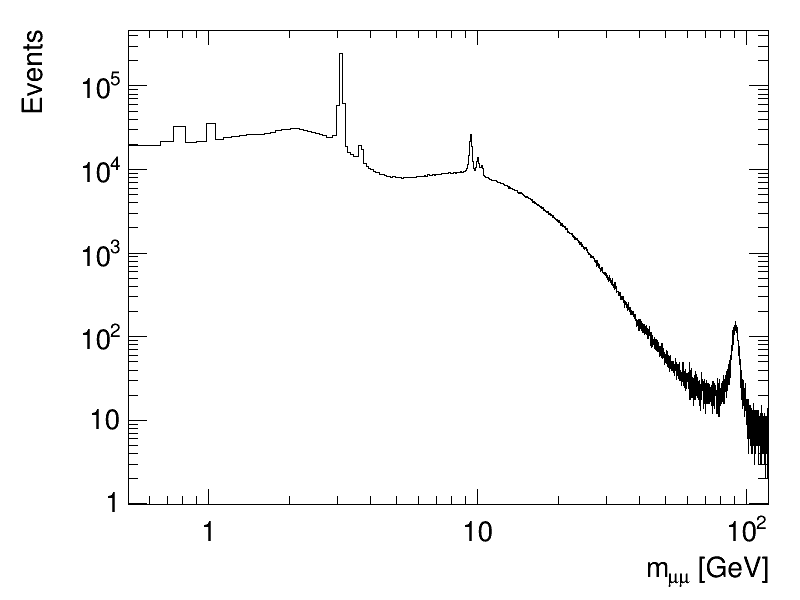

In [27]:
masses = get_masses('events.root')
mass_hist = Hist(1500, 0.5, 120)
fill_hist(mass_hist, masses)
plot_hist(mass_hist)

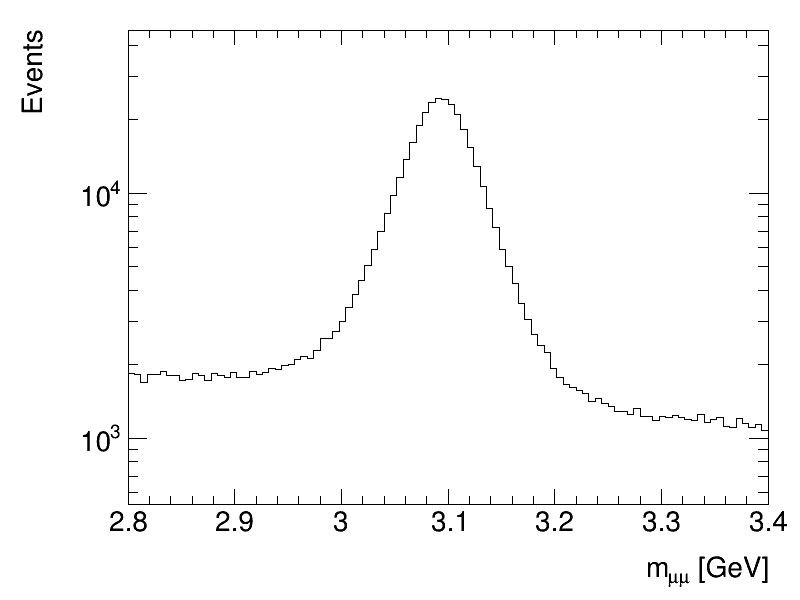

In [28]:
mass_hist_zoomed = Hist(100, 2.8, 3.4)
fill_hist(mass_hist_zoomed, masses)
plot_hist(mass_hist_zoomed, logx=False)

* These events were extracted from the CMS Mu Primary Dataset on the CERN Open Data Portal: http://opendata.cern.ch/record/14. 
* Thanks to http://openstack.cern.ch for providing a CernVM running SL5 where I could set up CMSSW 4.2.8 and to https://github.com/tpmccauley/dimuon-filter for generating the CSV from CMS AODs.